In [7]:
!pip install geopandas
!pip install seaborn
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [8]:
# Carga de paquetes necesarios para graficar

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [9]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<AxesSubplot: >

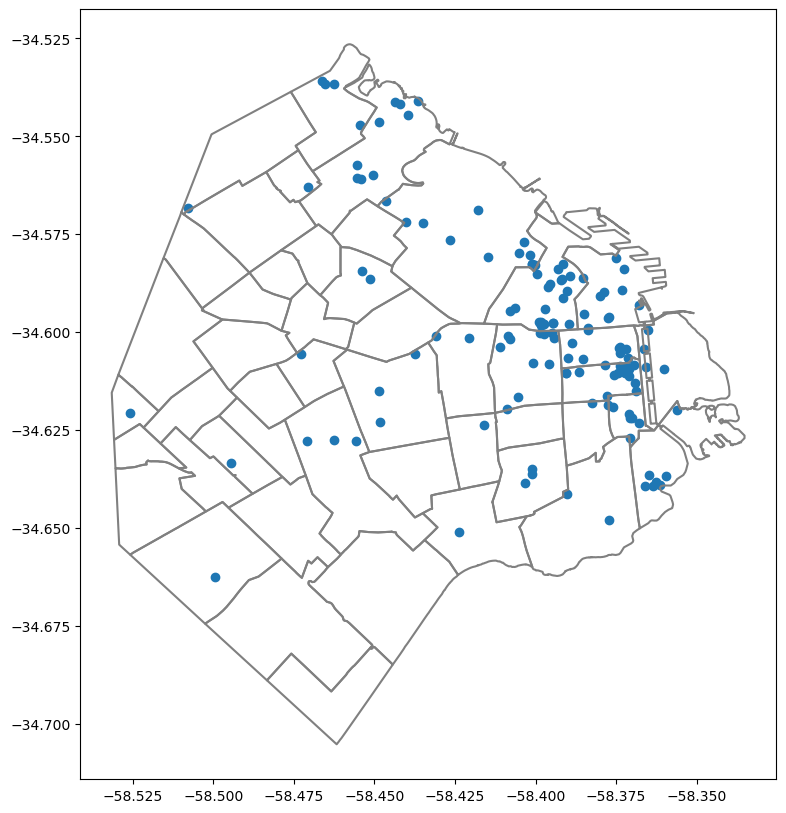

In [10]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [11]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [36]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [37]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

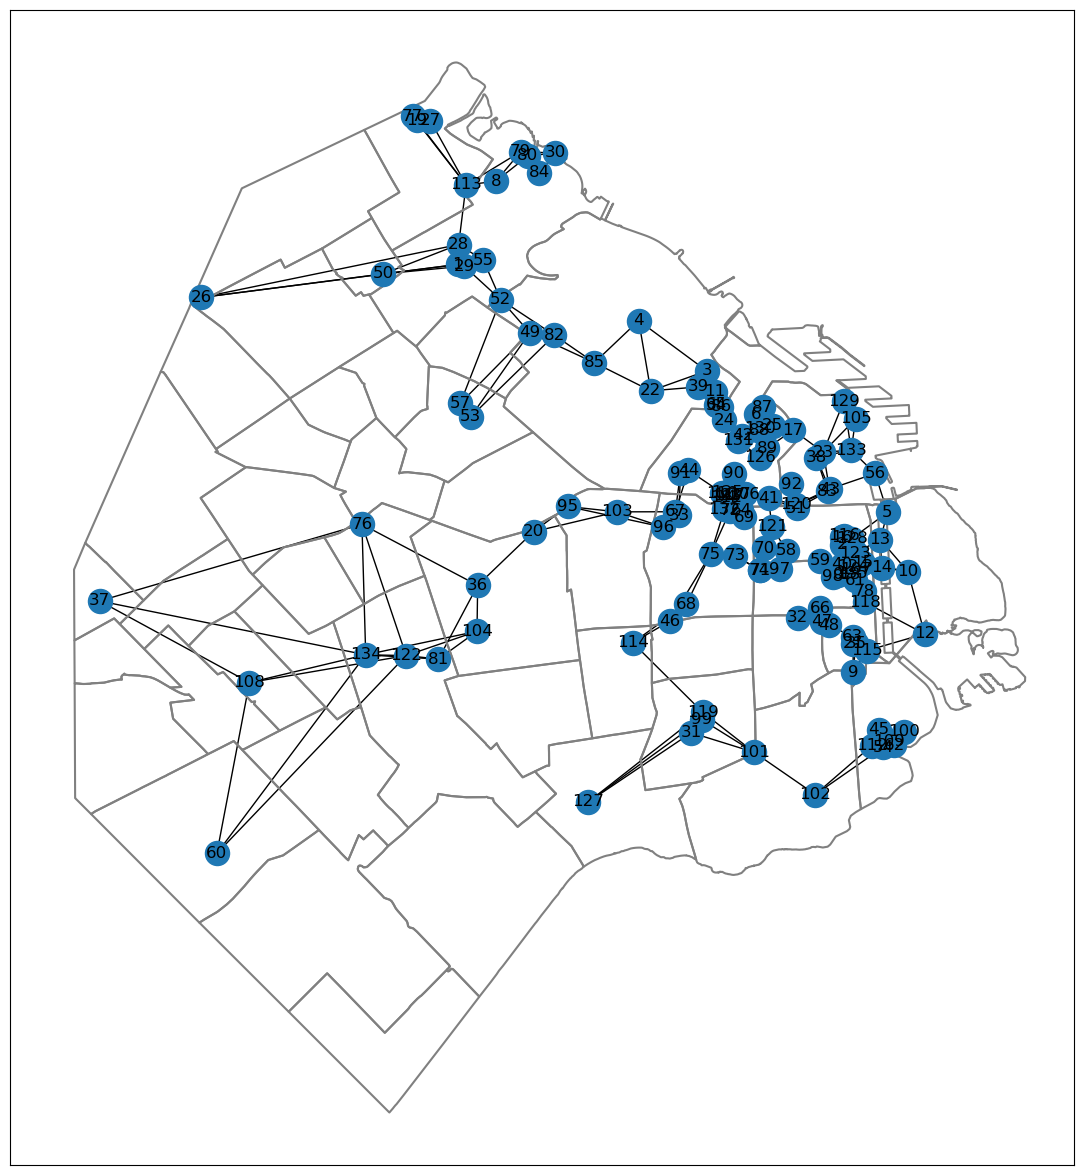

In [38]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:
Buscamos llegar a $M = \frac{N}{\alpha} (I - (1 - \alpha) C)$ y $b=1$  

Partimos de la ecuacion de $p = (1 - \alpha) C p + \frac{\alpha}{N} 1$  

Ahora pasamos restando el termino  $(1 - \alpha) C p$  para el otro lado entonces nos queda la ecuacion: $p - (1 - \alpha) C p = \frac{\alpha}{N} 1$  

Luego sacamos Factor Comun **$p$** y nos queda la siguiente ecuacion:  $ (I-(1 - \alpha)C) p = \frac{\alpha}{N} 1$

Por ultimo pasamos diviendo el termino $\frac{\alpha}{N}$ y obtenemos lo siguiente: $  \frac{N}{\alpha} (I-(1 - \alpha)C) p = 1$

Y de esa manera conseguimos lo que buscabamos $Mp=b$ con $M = \frac{N}{\alpha} (I - (1 - \alpha) C)$ y $b=1$ 



## Punto 2:
Las condicion que se deben cumplir es basicamente que la matriz M sea inversible y eso se puede ver de varias maneras:

**1**.Determinante de la matriz debe ser distinto de 0  
**2**.Las filas de la matriz tienen que ser Linealmente Independientes  
**3**.El nucleo tiene que ser solo el 0  
**4**.La matriz debe ser estrictamente diagonal dominante

Pero lo vamos a demostrar de la siguiente manera:  
Tomando $B = (1 - \alpha) C$  
Sabiendo que $||B||_1$< 1 (ya que $C$ es estocástica porque la suma de sus columnas es 1  y esta siendo multiplicada por un escalar menor que 1)  

Queremos probar por el absurdo que $(I-B)$ es inversible utilizando la siguiente ecuacion:  

$(I-B)x=0$ con $x\neq0$  

Hacemos la distributiva del producto:   

$x-Bx=0$ 

Despejamos $x$:  

$Bx=x$ 

Aplicamos norma 1 en ambos lados:  

$||Bx||_1=||x||_1$   

Por propiedad de Normas Inducidas sabemos que:   

$||Bx||_1 \leq ||B||_1 ||x||_1$  

Por lo tanto como $||Bx||_1=||x||_1$ entonces:  

$||x||_1 \leq ||B||_1 ||x||_1$  

Como $||x||_1$ es distinto de 0, dividimos ambos lados de la ecuacion por $||x||_1$:    

$1 \leq ||B||_1$  

Sabemos que esto es un absurdo puesto que $||B||_1$< 1 por lo tanto probamos que $(I-B)$ es inversible.

A partir de esto, como $M = \frac{N}{\alpha} (I - B)$ y $\frac{N}{\alpha}$ es un escalar que no modifica su inversibilidad, podemos concluir que $M$ es inversible si $0<\alpha<1$. 




## Punto 3:

In [59]:

from scipy.linalg import solve_triangular
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

def calculaLU(A):
    m=A.shape[0]
    n=A.shape[1]
    if m!=n:  #Aca chequeamos que la matriz sea cuadrada
        print('Matriz no cuadrada') 
        return
    L=np.eye(n) #Creamos L 
    U=A.copy()  #Creamos U
    for j in range(n): #Con este nido de ciclos redefinimos L y U
        for i in range(j+1,n):
            L[i,j]=U[i,j]/U[j,j] #Rellenamos L con los valores U divididos por los de la diagonal 
            U[i,:]=U[i,:]-L[i,j]*U[j,:] #Rellenamos U con los valores de la filas de U menos los valores correspondientes de L mulplicado por las filas anteriores de U
    return L, U

def calcula_matriz_C(A): 
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C
    n=A.shape[0] #Tomamos dimension de A
    
    At=np.transpose(A) #Trasponemos A
    
    k=np.eye(n) #Creamos k
    for i in range(n): #Llenamos la diagonal de k con la suma de las filas
        v=0
        for j in range(n): #Sumamos el valor de las filas
            v+=A[i,j]
        k[i,i]=v  
    Kinv = np.eye(n) # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de A
    for i in range(n): #Calculamos la inversa
        Kinv[i,i] = 1/k[i,i]
    C = At@Kinv # Calcula C multiplicando Kinv y A
    return C


def calcula_pagerank(A,alfa):
    # Función para calcular PageRank usando LU
    # A: Matriz de adyacencia
    # d: coeficientes de damping
    # Retorna: Un vector p con los coeficientes de page rank de cada museo
    C = calcula_matriz_C(A)
    N = A.shape[0] # Obtenemos el número de museos N a partir de la estructura de la matriz A
    I = np.eye(N) #Creamos la Identidad
    M = (N/alfa)*(I-(1-alfa)*C) #creamos M
    L, U = calculaLU(M) # Calculamos descomposición LU a partir de C y d
    b = np.empty(A.shape[0]) # Vector de 1s, multiplicado por el coeficiente correspondiente usando d y N.
    b.fill(alfa/N) #Llenamos b con d/N
    Up = scipy.linalg.solve_triangular(L,b,lower=True) # Primera inversión usando L
    p = scipy.linalg.solve_triangular(U,Up) # Segunda inversión usando U
    return p

def grafico(D,m,alfa):
    A = construye_adyacencia(D, m) #creamos A

    G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    # Construimos un layout a partir de las coordenadas geográficas
    G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
    fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    pr = calcula_pagerank(A,alfa)# Calculamos el PageRank
    pr = pr/pr.sum() # Normalizamos para que sume 1
    Nprincipales = 3 # Cantidad de principales
    principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
    nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
    nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres
    return principales

def juntar_Arrays(tops):
    l=[] #Creamos la lista vacia
    for t in tops: #Llenamos la lista l con los elementos sin repetir de los arrays de tops
        for i in t:
            if i not in l:
                l.append(i)
    return l   



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Punto 3)a)

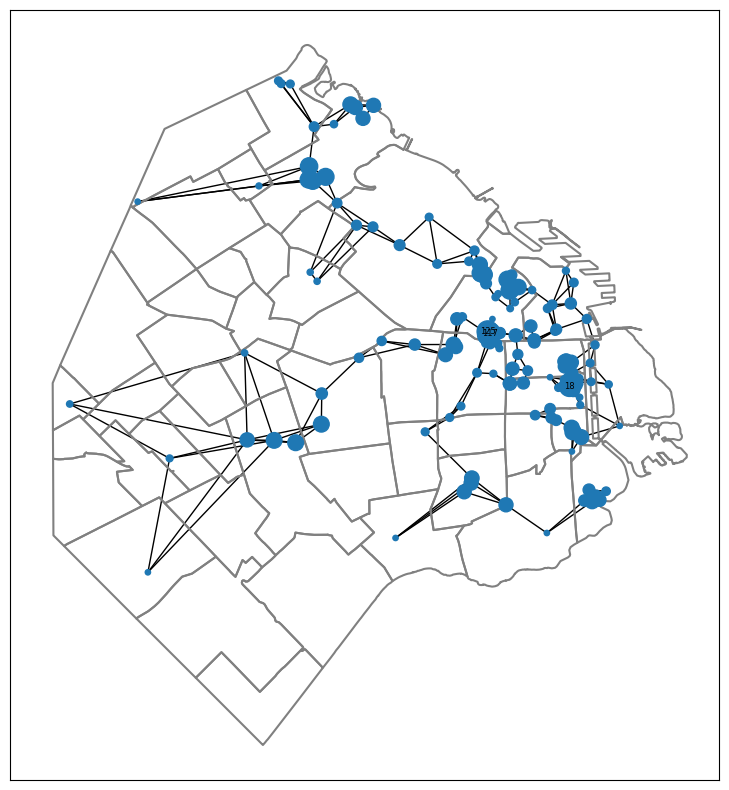

In [32]:
top0 = grafico(D,3,1/5)
ltops = [top0]
print(juntar_Arrays(ltops))

## Punto 3)b)

[34, 107, 65, 117, 125, 93, 15, 135, 124]


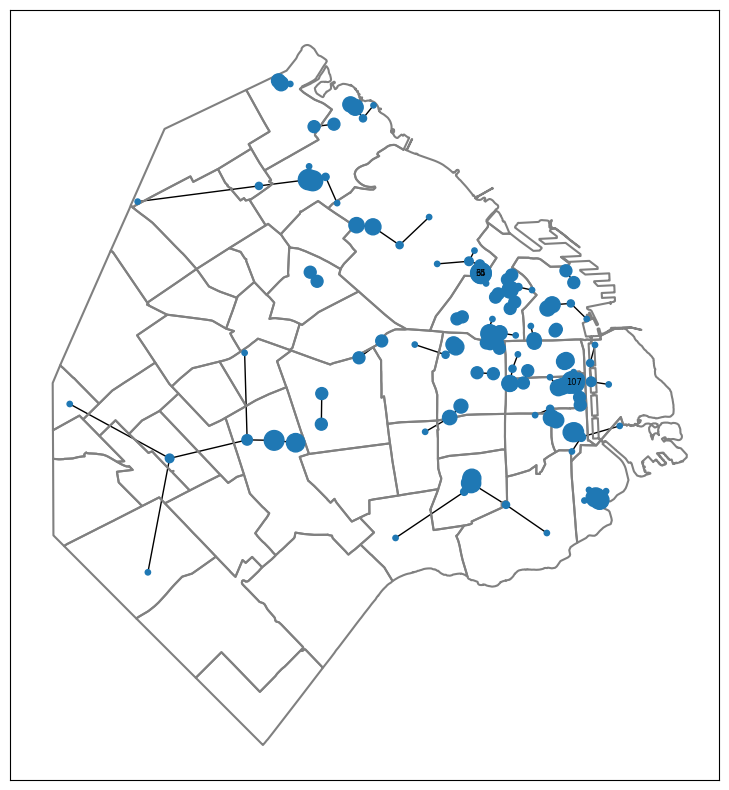

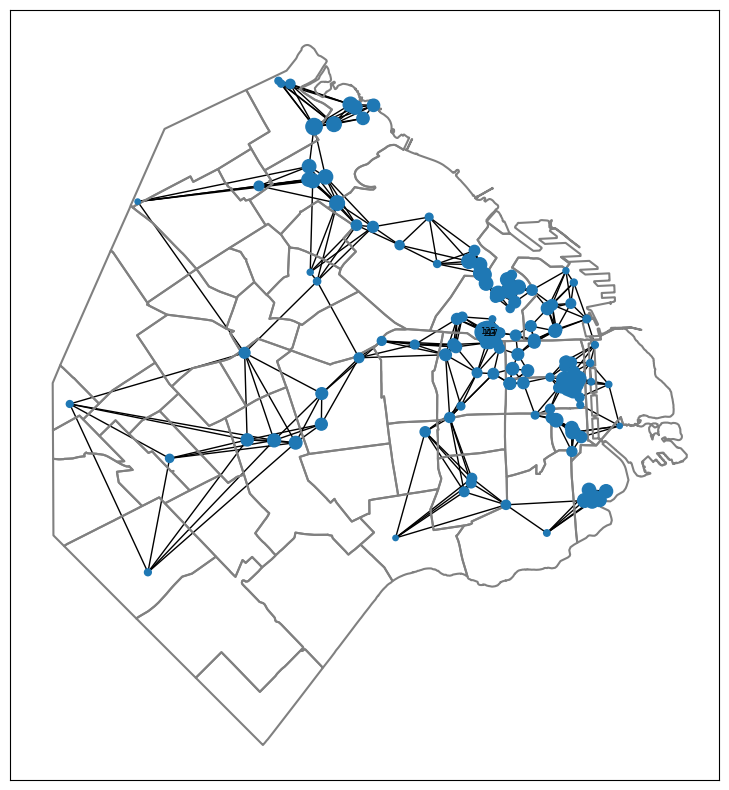

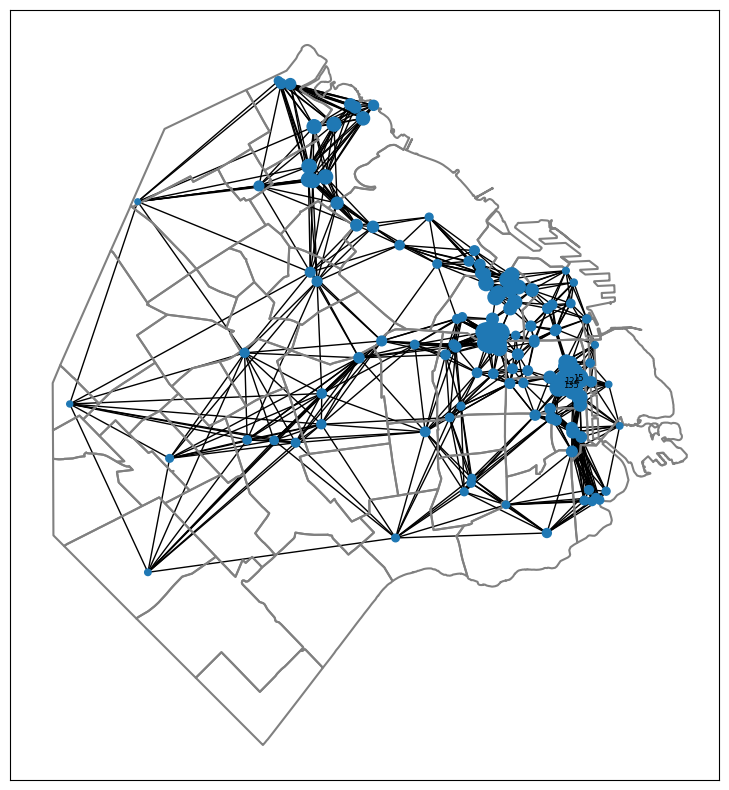

In [57]:
top1 = grafico(D,1,1/5)
top2=grafico(D,5,1/5)
top3=grafico(D,10,1/5)
ltops = [top1,top2,top3]
print(juntar_Arrays(ltops))


## Punto 3)c)

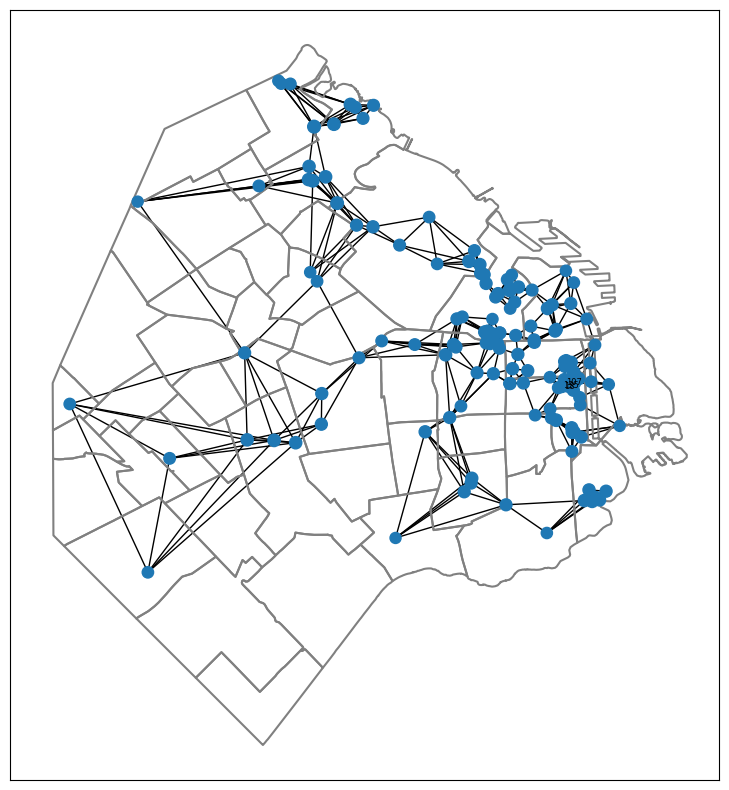

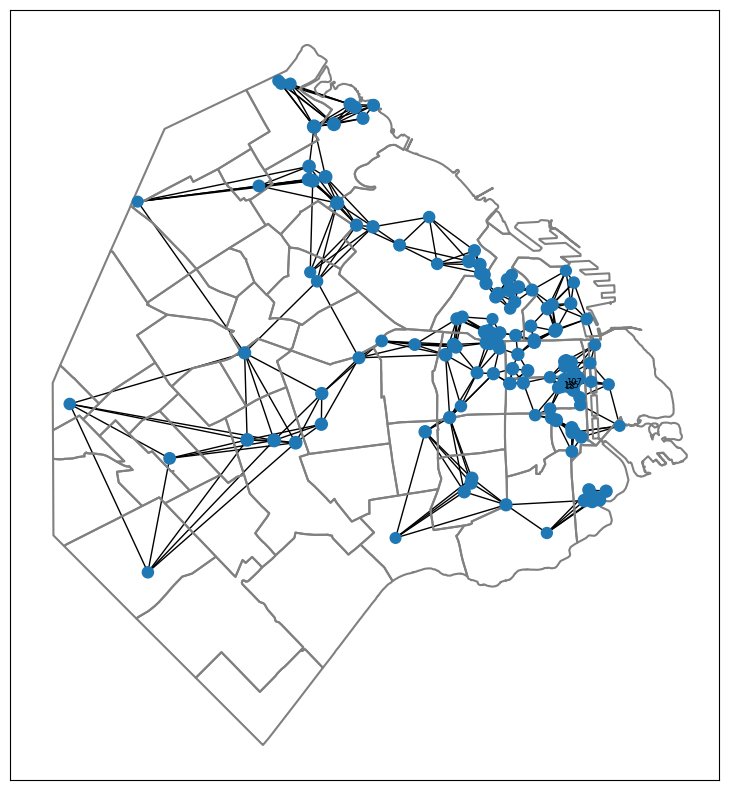

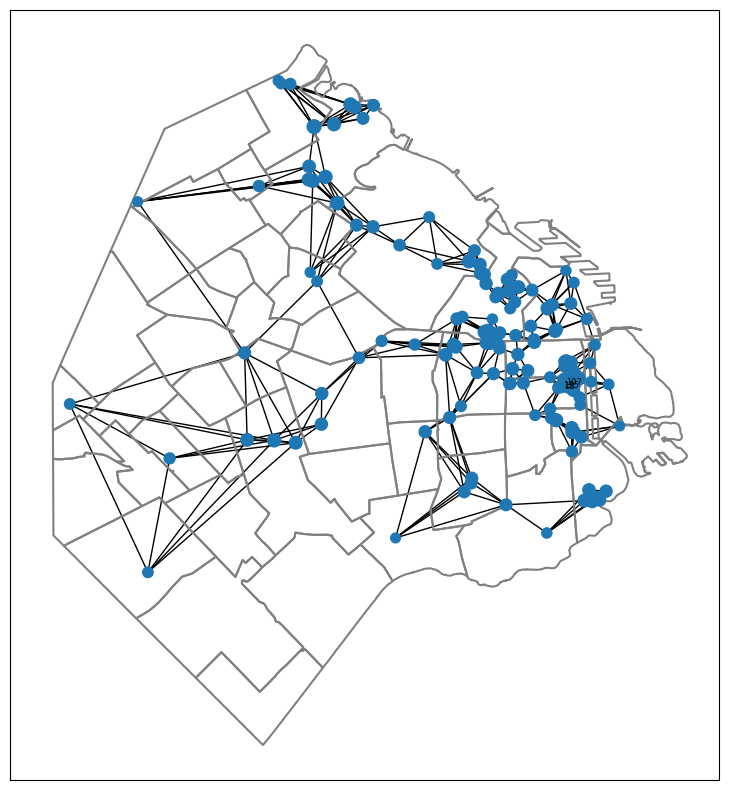

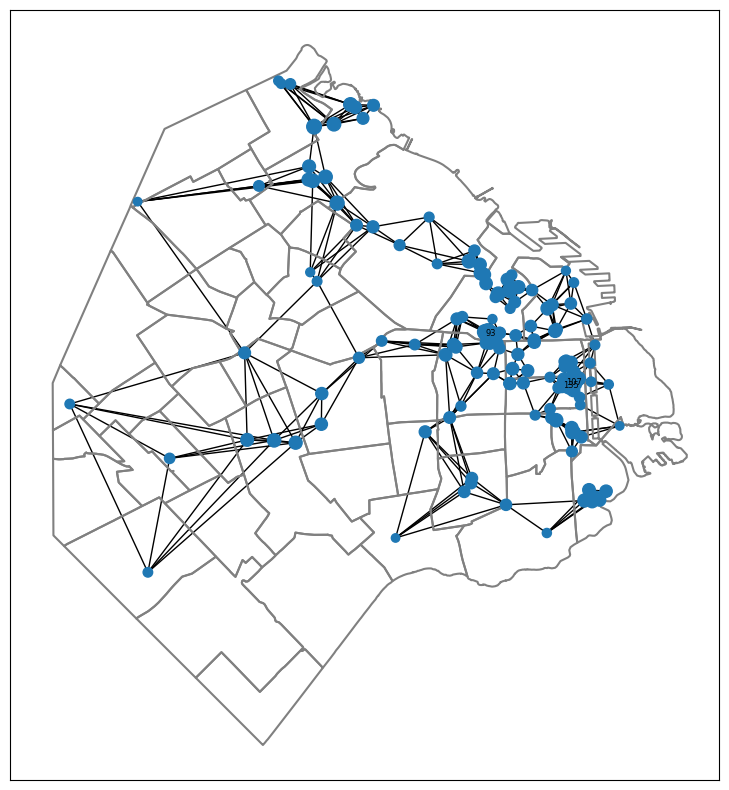

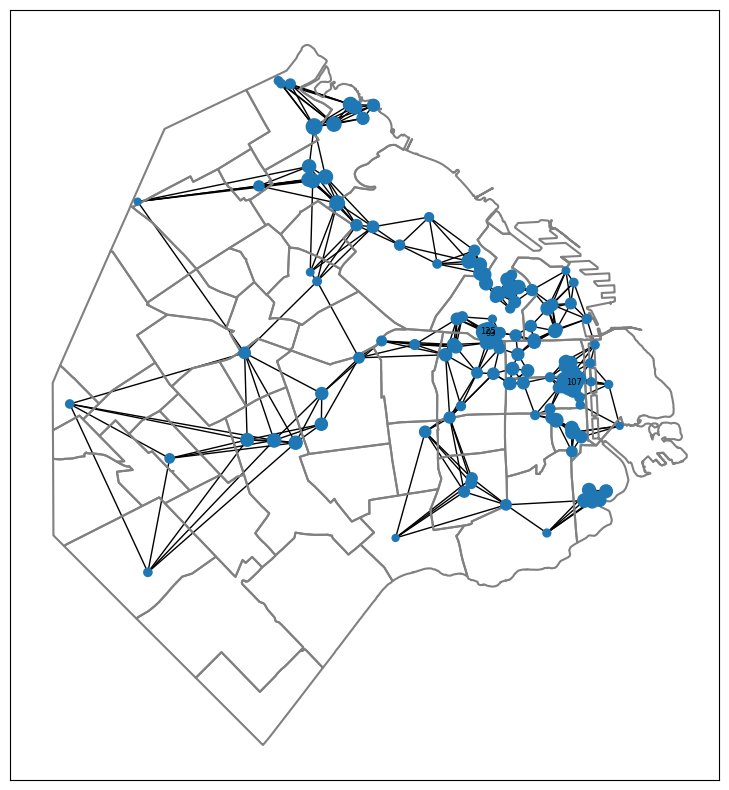

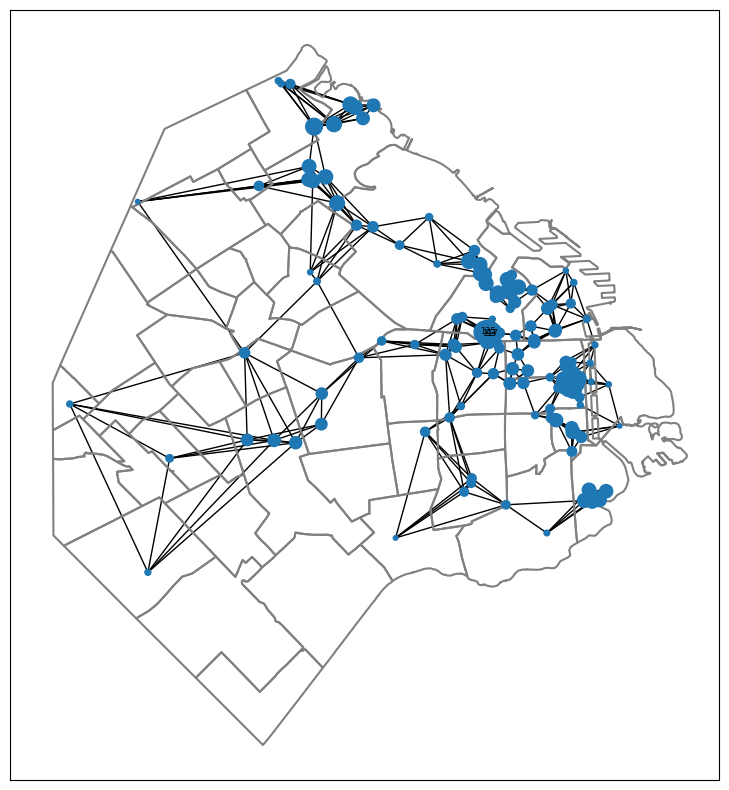

In [18]:
top4=grafico(D,5,6/7)
top5=grafico(D,5,4/5)
top6=grafico(D,5,2/3)
top7=grafico(D,5,1/2)
top8=grafico(D,5,1/3)
top9=grafico(D,5,1/7)
ltops = [top4,top5,top6,top7,top8,top9]
print(juntar_Arrays(ltops))

## Punto 3)a)a)

## Punto 3)b)b)


## Punto 4:
Para este punto partimos de la ecuacion:  
$$\mathbf{v} = B^{-1} \mathbf{w}$$ siendo **w** el vector que en cada componente tiene la cantidad total de visitantes por museo y $B = \sum_{k=0}^{r-1} C_k$  

Se busca probar que **v** es el vector que tiene en cada componente la cantidad de personas que tuvieron ese museo como entrada.  

Asumiendo que B es inversible podemos llegar a la siguiente ecuacion: $$\mathbf{v} B = \mathbf{w}$$

De aca tomamos B generica: ($C_0+C_1+C_2+...+C_k$) y  tambien el **w** generico: ($w_0,w_1,w_2,...,w_i$)

Si ahora hacemos el producto de B por **v**=$v_0$ obetenemos el siguiente resultado: ($v_0*C_0+v_0*C_1+v_0*C_2+...+v_0*C_k$)  

Y por ultimo igualamos ambos vectores ($v_0*C_0+v_0*C_1+v_0*C_2+...+v_0*C_k$) = ($w_0,w_1,w_2,...,w_i$)  

Para que esa igualdad se cumpla tienen que ser iguales coordenada a coordenada entonces se obtiene:  
                                    $$(v_0*C_0=w_0), (v_0*C_1=w_1), (v_0*C_2=w_2) ,..., (v_0*C_k=w_i)$$  
De esa manera se consigue probar lo que queriamos ya que usando que **v** tiene las perosnas que ingresaron a traves de un museo, luego de k pasos se puede obtener la cantidad de visitantes haciendo $v_0*C_k$, que es justamente lo que nos da la ecucion de arriba para cada museo el total de visitantes esta deifinido por esa ecuacion que fue demostrada                                 
                                    


## Punto 5:

In [75]:
def calcula_matriz_C_continua(D): 
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C en versión continua
    D = D.copy()
    F = 1/D
    np.fill_diagonal(F,0)

    n=D.shape[0] #Tomamos la dimension de D
    k=np.eye(n) #Creamos k
    for i in range(n): #Llenamos la diagonal de k con la suma de las filas
        v=0
        for j in range(n): #Sumamos los elementos de las filas
            v+=D[i,j]
        k[i,i]=v
    Kinv = np.eye(n) # Creamos K inversa
    for i in range(n): #Rellenamos la diagonal de K inversa
        Kinv[i,i] = 1/k[i,i] # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de F 
    C = F@Kinv # Calcula C multiplicando Kinv y F
    return C
#a=np.array([[5,0,0],[0,6,0],[0,0,9]])
#print(calcula_matriz_C_continua(D))
def calcula_B(C,cantidad_de_visitas):
    # Recibe la matriz T de transiciones, y calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes
    # suponiendo que cada visitante realizó cantidad_de_visitas pasos
    # C: Matirz de transiciones
    # cantidad_de_visitas: Cantidad de pasos en la red dado por los visitantes. Indicado como r en el enunciado
    # Retorna:Una matriz B que vincula la cantidad de visitas w con la cantidad de primeras visitas v
    n = C.shape[0] #Tomamos la Dimension de C
    B = np.eye(n) #Creamos la C elevado a 0
    for i in range(cantidad_de_visitas-1): # Sumamos las matrices de transición para cada cantidad de pasos
        cm = C.copy() #Creamos una copia de C
        for j in range(i): #Multiplicamos C j veces
            cm = cm@C
        B+=cm
    return B

#punto5
w = np.loadtxt("visitas.txt")
def ecuacion5(D): 
    C=calcula_matriz_C_continua(D)   
    B=calcula_B(C,3)
    L,U=calculaLU(B)
    y = scipy.linalg.solve_triangular(L,w,lower=True) 
    v = scipy.linalg.solve_triangular(U,y)
    return v

ecuacion5(D)
    
    

/tmp/ipykernel_5641/701988893.py:6: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


array([1158.99982074, 1077.99994811, 1136.99982764, 1072.99990775,
       1096.99994164, 1082.99989995, 1095.99985984, 1087.99948439,
       1125.99995925, 1082.99991518, 1150.99990653, 1104.99988116,
       1109.99992835, 1101.99988186, 1109.9998761 , 1169.99983464,
       1083.99980772, 1119.99987971, 1119.99978212, 1105.9999605 ,
       1159.99994495, 1145.99985748, 1072.99992345, 1086.99987696,
       1055.99986605, 1112.99985965, 1148.9999766 , 1081.9999648 ,
       1087.99995521, 1052.99994698, 1114.99996003, 1114.99993992,
       1145.99989214, 1132.99986691, 1136.99969899, 1089.99985643,
       1091.99995451, 1030.99997963, 1084.99987207, 1102.99989818,
       1076.9998206 , 1127.99984452, 1171.99984429, 1115.99984293,
       1129.9998749 , 1084.99992791, 1012.99992319, 1172.99987578,
       1119.99987738, 1080.9999483 , 1115.99996575, 1051.99982865,
       1117.99995308, 1069.99995221, 1086.9999231 , 1088.99995297,
       1124.99990514, 1033.99995332, 1104.99986005, 1123.99985

## Punto 6:

In [76]:
def ecuacion(D):
    C=calcula_matriz_C_continua(D)   
    B=calcula_B(C,3)
    numero_condicionB=np.linalg.cond(B,1)
    error=0.05
    error_estimadoV=numero_condicionB*error
    return error_estimadoV,numero_condicionB

ecuacion(D)


/tmp/ipykernel_5641/701988893.py:6: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


(0.05000006310662717, 1.0000012621325434)

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

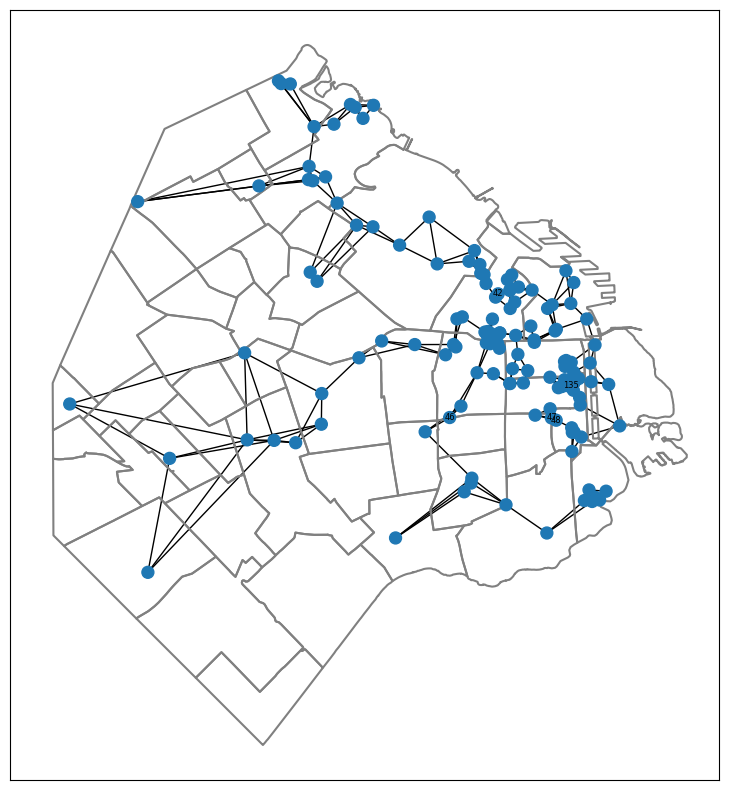

In [61]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = calcula_pagerank(A,1)# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres